#### PI7-3: AE & VAE
This notebook contains all the implementation and evaluation of the research performed on autoencoders en variational autoencoders.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.z_space = z_space

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(512, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [4]:
class Decoder(nn.Module):
    def __init__ (self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # z_space->256, 256->128, 128->64, 64->1 
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.encode = Encoder(z_space)
        self.decode = Decoder(z_space)

    def forward(self, X: torch.Tensor):
        z = self.encode(X)
        y = self.decode(z)
        
        return z, y

In [6]:
enc = Encoder(2)
dec = Decoder(2)
x = torch.randn(16, 3, 64, 64)
dec(enc(x)).shape

torch.Size([16, 3, 64, 64])

In [7]:
transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [8]:
'''Adjustable constants'''
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

Z_DIM = 256

NUM_WORKERS = 4

In [9]:
train_dir = 'data/cifar10/train'
test_dir = 'data/cifar10/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 3, 64, 64]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 3, 64, 64]), y_val shape: torch.Size([5000])


#### Training Loop AE

In [10]:
generator = AutoEncoder(z_space=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.MSELoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        _, preds = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        _, preds = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    z, preds = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.11472193896770477, val_loss 0.04546079784631729
epoch 1, train_loss 0.03829185664653778, val_loss 0.032353971153497696
epoch 2, train_loss 0.027152419090270996, val_loss 0.02410159446299076
epoch 3, train_loss 0.023075707256793976, val_loss 0.022291317582130432
epoch 4, train_loss 0.021424444392323494, val_loss 0.0207135621458292
epoch 5, train_loss 0.019860967993736267, val_loss 0.018179569393396378
epoch 6, train_loss 0.01776830479502678, val_loss 0.01723594404757023
epoch 7, train_loss 0.016773797571659088, val_loss 0.01640918478369713
epoch 8, train_loss 0.016204478219151497, val_loss 0.016031414270401
epoch 9, train_loss 0.015627823770046234, val_loss 0.015559458173811436
epoch 10, train_loss 0.015428168699145317, val_loss 0.015145339071750641
epoch 11, train_loss 0.014908154495060444, val_loss 0.015237044543027878
epoch 12, train_loss 0.01470222044736147, val_loss 0.014594128355383873
epoch 13, train_loss 0.014395780861377716, val_loss 0.014388201758265495
e

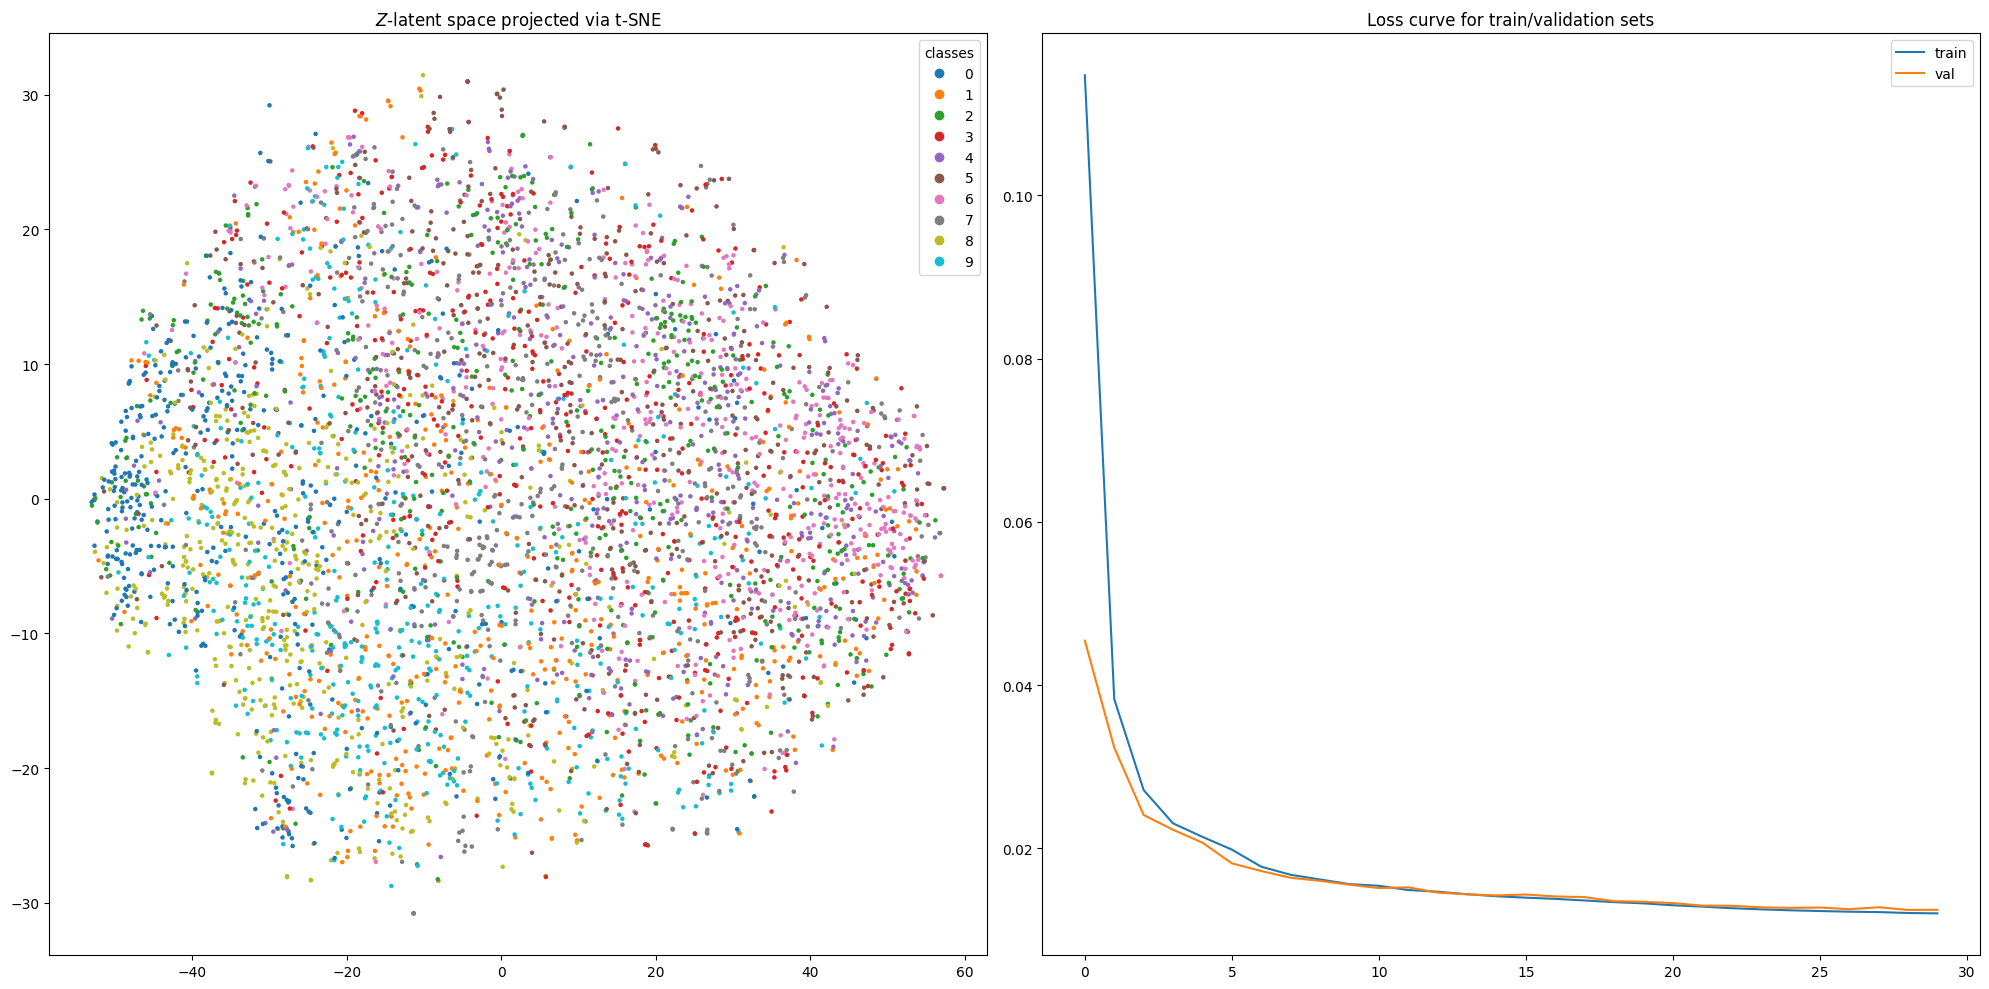

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Flatten z and move to numpy
z = z.view(z.shape[0], -1).cpu().detach().numpy()

# Apply t-SNE to reduce dimensionality
z_proj = TSNE(n_components=2, random_state=42).fit_transform(z)

# Plot t-SNE projection
sc = ax1.scatter(z_proj[:, 0], z_proj[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space projected via t-SNE")

# Plot training and validation loss curves
ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048493057..0.7631147].


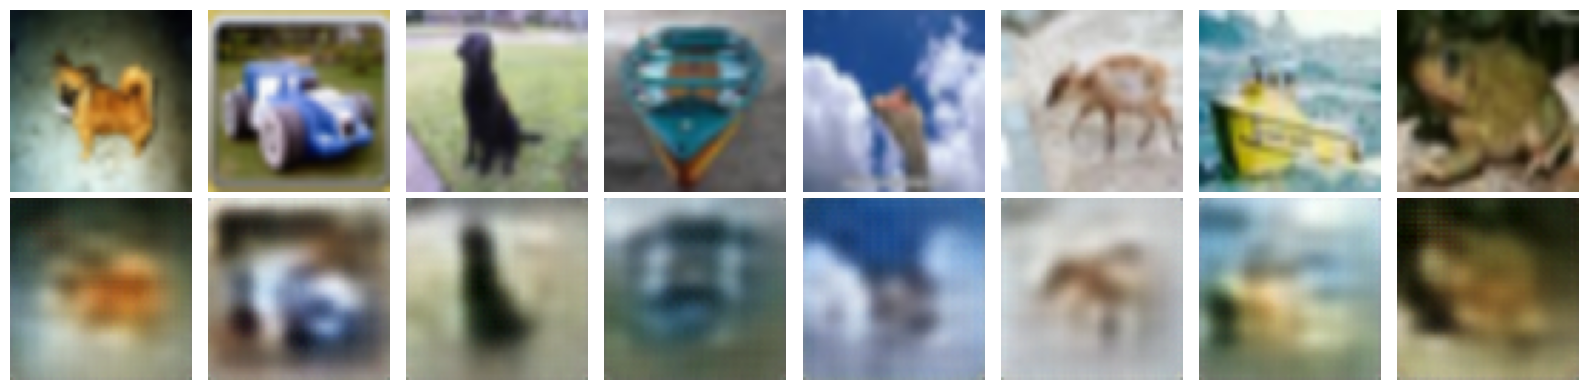

In [12]:
generator.eval()
with torch.no_grad():
    _, recon = generator(X_val[:8].to(DEVICE))

recon = recon.cpu().squeeze().numpy()
original = X_val[:8].squeeze().numpy()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
""" h, w = 15, 15
z_dim = 256

z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.zeros(h * w, z_dim, 1, 1).to('cuda')
zz[:, :2, 0, 0] = torch.stack([z1.flatten(), z2.flatten()], dim=1)
#zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = torch.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
#y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

y_preds = y_preds.reshape(h, w, 3, 64, 64)  # [15, 15, 3, 64, 64]
y_preds = y_preds.permute(0, 3, 1, 4, 2)    # [15, 64, 15, 64, 3]
y_preds = y_preds.reshape(h * 64, w * 64, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$') """

/home/impl1ng/Documents/school/encoders/.venv/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AttributeError: 'AutoEncoder' object has no attribute 'dec'

In [18]:
class VAEncoder(nn.Module):
    def __init__(self, z_space=3):
        super().__init__()
        self.z_space = z_space
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [19]:
class VADecoder(nn.Module):
    def __init__(self, z_space=3):
        super().__init__()
        self.z_space = z_space
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [20]:
enc = VAEncoder(3)
dec = VADecoder(3)
x = torch.randn(16, 3, 64, 64)
dec(enc(x)).shape

torch.Size([16, 3, 64, 64])

In [21]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = VAEncoder(2*z_size)
        self.dec = VADecoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var

In [22]:
x = torch.randn(16, 3, 64, 64)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 3, 64, 64]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

In [23]:
EPOCHS = 80
BATCH_SIZE = 512
LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.9
NUM_WORKERS = 4
# Model constants
Z_DIM = 512
LAMBDA_REC_ERR = 1000

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [24]:
train_dir = 'data/cifar10/train'
test_dir = 'data/cifar10/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 3, 64, 64]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 3, 64, 64]), y_val shape: torch.Size([5000])


In [25]:
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_val shape: torch.Size([5000, 3, 64, 64])
X_test shape: torch.Size([5000, 3, 64, 64])


#### Training Loop VAE

In [26]:
generator = VAE(z_size=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to(DEVICE))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, X_val.to(DEVICE))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to(DEVICE))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = LAMBDA_REC_ERR * criterion(preds, X_test.to(DEVICE))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")


epoch 0, train_loss 700.2469482421875, val_loss 655.3494873046875
epoch 1, train_loss 649.4093627929688, val_loss 647.7368774414062
epoch 2, train_loss 642.6069946289062, val_loss 639.8802490234375
epoch 3, train_loss 635.7562255859375, val_loss 635.52392578125
epoch 4, train_loss 632.7346801757812, val_loss 633.3310546875
epoch 5, train_loss 629.7062377929688, val_loss 630.0009765625
epoch 6, train_loss 627.7119140625, val_loss 629.0213623046875
epoch 7, train_loss 627.0182495117188, val_loss 628.7813110351562
epoch 8, train_loss 626.3027954101562, val_loss 627.7479858398438
epoch 9, train_loss 625.8223876953125, val_loss 627.5966796875
epoch 10, train_loss 625.4546508789062, val_loss 627.402587890625
epoch 11, train_loss 624.962158203125, val_loss 626.8079223632812
epoch 12, train_loss 624.7596435546875, val_loss 626.7291870117188
epoch 13, train_loss 624.5144653320312, val_loss 626.6570434570312
epoch 14, train_loss 624.3272094726562, val_loss 626.4384155273438
epoch 15, train_loss 

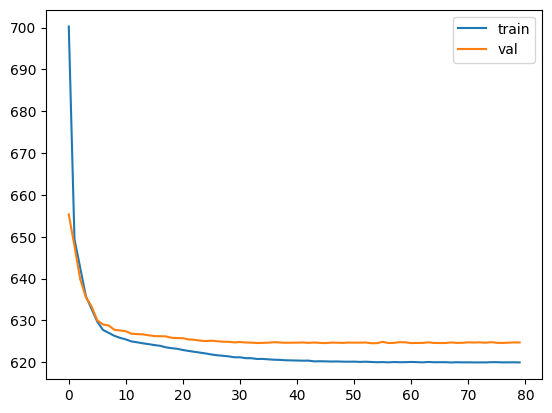

In [27]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

torch.Size([3, 64, 64])


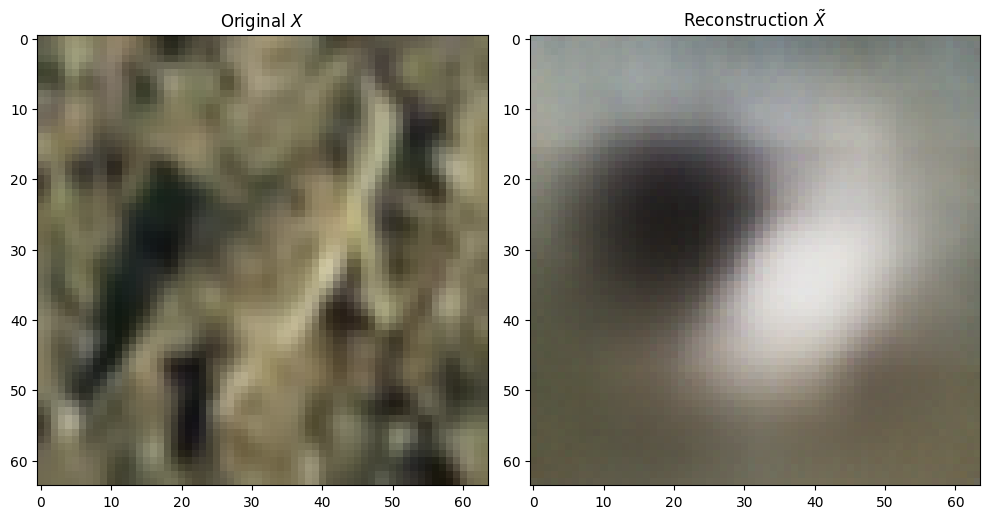

In [28]:
idx = 10

X_sample = X_test[idx].to(DEVICE)

print(X_sample.shape)
X_sample = X_sample.unsqueeze(0)  # (1, 3, 64, 64)
y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Original $X$")
ax2.set_title(r"Reconstruction $\tilde{X}$")

ax1.imshow(X_sample.squeeze(0).permute(1,2,0).cpu())
ax2.imshow(F.sigmoid(y_pred).detach().cpu().squeeze(0).permute(1,2,0))

plt.tight_layout()

Text(0, 0.5, '$Z_2$')

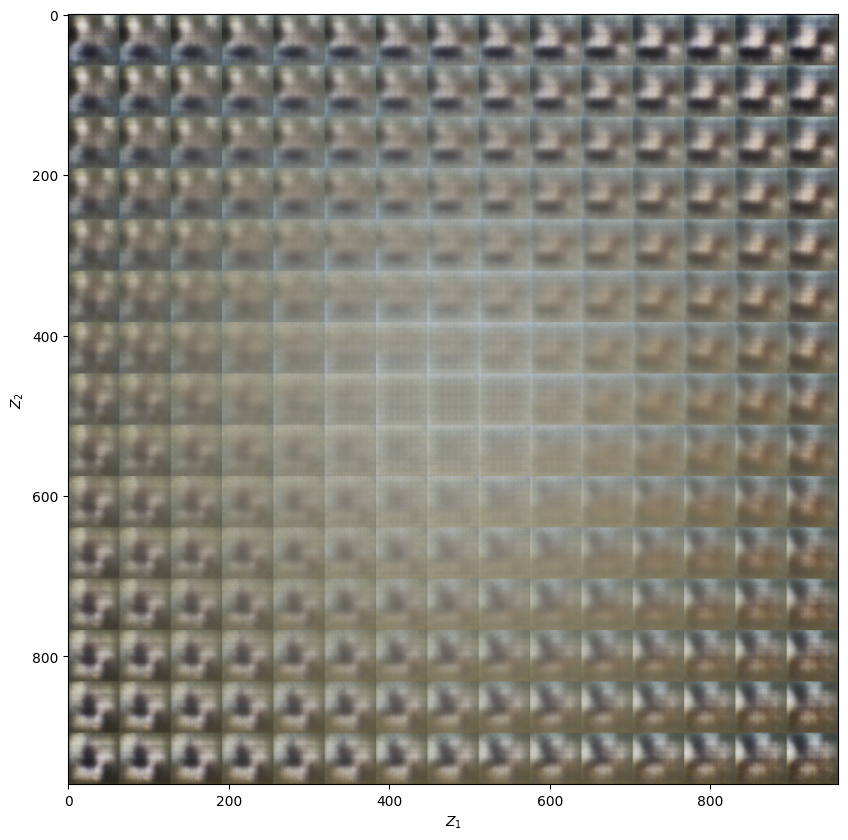

In [29]:
h, w = 15, 15
z_dim = 512

z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.zeros(h * w, z_dim, 1, 1).to('cuda')
zz[:, :2, 0, 0] = torch.stack([z1.flatten(), z2.flatten()], dim=1)
#zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = torch.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
#y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

y_preds = y_preds.reshape(h, w, 3, 64, 64)  # [15, 15, 3, 64, 64]
y_preds = y_preds.permute(0, 3, 1, 4, 2)    # [15, 64, 15, 64, 3]
y_preds = y_preds.reshape(h * 64, w * 64, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')